In [2]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install

# Sensitivity analysis for a piston model

In many computational problems there are a few key inputs that actually dictate the state of the output. Computing the Sobol' indices of the inputs is one approach to determine which inputs are the *drivers*. Typically computation of the Sobol' indices involves a large number of samples -- significantly more than required to get the variance in the data. However as shown in Blatman et al. [1], using orthogonal polynomials these can be computed with relative ease. In this notebook we demonstrate how we can compute these indices using `equadratures`. 

We consider the well-known piston problem from Kenett et al. [2] that is a non-linear, seven-dimensional problem that outputs the piston cycle time given various piston parameters. These parameters and their bounds are shown in the table below.

Variable | Range            | Description
:--------|:-----------------|:---------------------
$M$      | [30, 60]         | Piston weight
$S$      | [0.005, 0.0020]  | Surface area
$V_0$    | [0.002, 0.010]   | Initial gas volume
$k$      | [1000,5000]      | Spring coefficient
$P_0$    | [90000, 110000]  | Atmospheric pressure
$T_a$    | [290, 296]       | Ambient temperature
$T_0$    | [340, 360]       | Filling gas temperature

The cycle time for the piston is given by

$$
C=2\pi\sqrt{\frac{M}{k+S^{2}\frac{P_{0}V_{0}T_{a}}{T_{0}V^{2}}}},
$$

where

$$
V=\frac{S}{2k}\left(\sqrt{A^{2}+4k\frac{P_{0}V_{0}}{T_{0}}T_{a}}-A\right),
$$

and $A=P_{0}S+19.62M-\frac{kV_{0}}{S}$. The estimated *unnormalized* Sobol' indices (denoted $\tau_i^2$) from Kenett et al. [2] are given to be:

Variable                          | $M$     | $S$   | $V_0$ | $k$   | $P_0$   | $T_a$   | $T_0$  |
:---------------------------------|:-------:|:-----:|:-----:|:-----:|:-------:|:-------:|:------:|
$10^2 \tau^{2}$ indices | 0.073   | 1.088 | 0.626 | 0.040 | 0.001   | -0.002  | -0.002 |

These values measure the effect of varying each of the 7 input parameters on the output, the piston cycle time $C$. Dividing these values by the variance of the output gives the normalised Sobol' indices. For example, the first order normalised Sobol' index for the $i^{th}$ input parameter is

$$
S_i = \frac{\tau_i^2}{\sigma^2}
$$

See Section 2.2 in [3] for further details. We wish to use Effective Quadratures to compute these values for the piston problem. 

As before, we begin by defining each parameter and its range using four points for each variable.

In [4]:
import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
import equadratures as eq

order_parameters = 3
mass     = eq.Parameter(distribution='uniform', lower=30.0, upper=60.0, order=order_parameters)
area     = eq.Parameter(distribution='uniform', lower=0.005, upper=0.020, order=order_parameters)
volume   = eq.Parameter(distribution='uniform', lower=0.002, upper=0.010, order=order_parameters)
spring   = eq.Parameter(distribution='uniform', lower=1000., upper=5000., order=order_parameters)
pressure = eq.Parameter(distribution='uniform', lower=90000., upper=110000., order=order_parameters)
ambtemp  = eq.Parameter(distribution='uniform', lower=290., upper=296., order=order_parameters)
gastemp  = eq.Parameter(distribution='uniform', lower=340., upper=360., order=order_parameters)
parameters = [mass, area, volume, spring, pressure, ambtemp, gastemp]

Then, we define the piston model:

In [7]:
def piston(x):
    mass, area, volume, spring, pressure, ambtemp, gastemp = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    A = pressure * area + 19.62*mass - (spring * volume)/(1.0 * area)
    V = (area/(2*spring)) * ( np.sqrt(A**2 + 4*spring * pressure * volume * ambtemp/gastemp) - A)
    C = 2 * np.pi * np.sqrt(mass/(spring + area**2 * pressure * volume * ambtemp/(gastemp * V**2)))
    return C

We will opt for a total order basis set with qr subsampling.

In [10]:
mybasis = eq.Basis('total-order')
mypoly  = eq.Poly(parameters, mybasis, method='least-squares',\
                  sampling_args={'mesh':'tensor-grid', 'subsampling-algorithm':'qr', 'sampling-ratio':1.0})

Now (and this is the important part), we wish to ascertain how many model evaluations will be required for computing these sensitivities. The objective is for these to be orders of magnitude lower than other methods for computing Sobol' indices.

In [11]:
mypoly.basis.cardinality

120

Excellent! So the number of model evaluations we will require is 120! Now lets compute the coefficients and get the Sobol indices to ascertain which of the variables above are the most important.

In [12]:
mypoly.set_model(piston)
mean, var = mypoly.get_mean_and_variance()
sobol = mypoly.get_sobol_indices(1)

For the *unnormalised* Sobol' indices we obtain 

In [13]:
for i in range(0, len(parameters)):
    print(float(sobol[(i,)]) * 10**2 * var)

0.08539566261615422
1.0891138923819914
0.6185474012210984
0.0461594487842166
0.003561262905089266
0.0011791102008189406
0.00039249850671305234


which are similar to the values obtained by Owen. Next, we plot the *normalized* Sobol' indices with the code below.

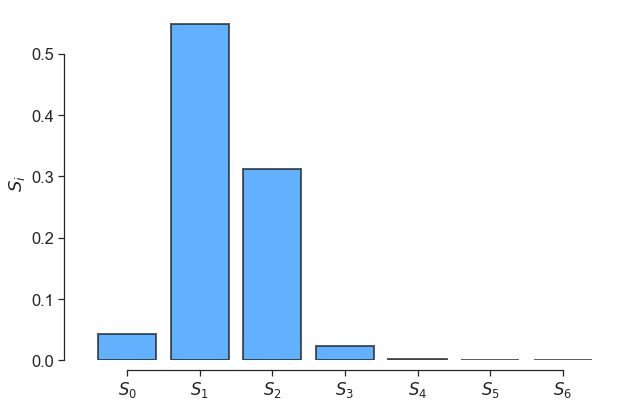

In [23]:
mypoly.plot_sobol()

We can also obtain higher order Sobol indices, which tell us about the importance of interaction between input parameters. For example, for the $2^{nd}$ order indices:

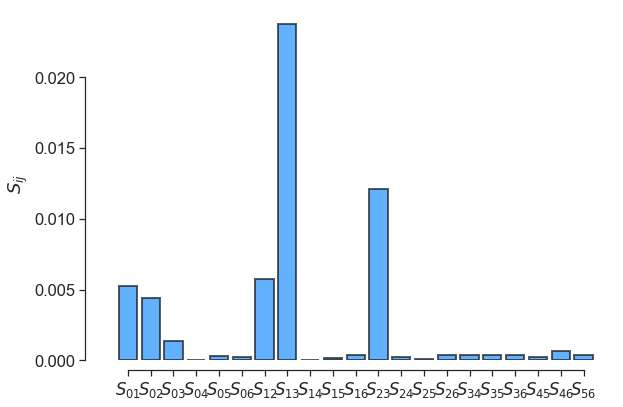

In [22]:
mypoly.plot_sobol(order=2)

### References

[1] Blatman, G., and Bruno S. (2011), Adaptive sparse polynomial chaos expansion based on least angle regression. Journal of Computational Physics 230.6: 2345-2367. [Paper](https://doi.org/10.1016/j.jcp.2010.12.021).

[2] Kenett, R., Shelemyahu Z., and Daniele A. (2013), Modern Industrial Statistics: with applications in R, MINITAB and JMP. John Wiley & Sons. [Book](https://dl.acm.org/doi/10.5555/2568447).

[3] Owen, A. B., Dick, J. and Chen, S. (2014), Higher order Sobol' indices. Information and Inference 3.1: 59-81. [Paper](https://doi.org/10.1093/imaiai/iau001).